In [78]:
def bcctcoreClassifier (asyMeasDict, colScarMeasDict):
    
    feat0=asyMeasDict['pLBC']
    
    feat1=asyMeasDict['pBCE']
    
    
    try:
        feat2=colScarMeasDict['cChi2b']
    except Exception:
        print ('NO cChi2b')
        feat2=0
   
    
    features = [feat0, feat1, feat2]
    
    return scorecardPrediction(features)
    
def scorecardPrediction(features) :
    classes = ["UNKNOWN", "EXCELLENT", "GOOD", "FAIR", "POOR"]
    prediction = -1
    points = 0.0
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128

    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727

    if (points < 0.1738):
        prediction = 1
    elif (points<0.3720):
        prediction = 2
    elif (points<0.7002):
        prediction = 3
    else:
        prediction = 4
    return prediction, classes[prediction]


### use RiskSLIM on aesthetic data only with columns chosen by old scorecard

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sbc import SBC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from scorecard import Scorecard


# columns thresholds
pLBC_thresholds = [0.0174, 0.1012, 0.1707]
pBCE_thresholds = [0.0184, 0.3684, 0.9219]
thresholds = {
    'pLBC Value': pLBC_thresholds,
    'pBCE Value': pBCE_thresholds,
    'sbcol1': [0.5],
    'sbcol2': [0.5]
}

# prediction thresholds
prediction_thresholds = [0.1738, 0.3720, 0.7002]


# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get train and test sets
train_X, test_X, train_y, test_y = train_test_split(aesthetic_evaluation_X, aesthetic_evaluation_y, test_size=0.25, random_state=42)

# do SBC on the train set
sbc = SBC()
sbc_train_X, sbc_train_y = sbc.reduction(train_X, train_y, 4)


# get encoded version of the data with differential coding
def disc_diff_coding(X, thresholds, categorical=[]):
    encoded_X = []
    for col in X.columns:
        if col not in thresholds.keys():
            continue  # skip columns not in thresholds
        if col in categorical:
            bin = pd.Categorical(X[col], categories=thresholds[col]).codes
            num_bins = len(thresholds[col])
        else:
            X_col_float = X[col].astype(float)
            bin = np.digitize(X_col_float, thresholds[col]) # gets bin number of each row
            num_bins = len(thresholds[col]) + 1
        
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bin >= i).astype(int)
        
        encoded_X.append(bin_df)

    # concatenate all encoded columns
    encoded_X = pd.concat(encoded_X, axis=1)

    return encoded_X



# encode the data
encoded_X = disc_diff_coding(sbc_train_X, thresholds)

# add the target variable as the first column, and substitute 0 by -1
encoded_X.insert(0, 'target', sbc_train_y.replace({0: -1}))

# to csv
encoded_X.to_csv('datasets/riskslim/aesthetic_old_scorecard.csv', index=False)

In [71]:
''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin3                         |          2 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpBCE Value-bin3                         |          0 points |   + ..... |
| featpBCE Value-bin2                         |          0 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featsbcol2-bin1                             |          0 points |   + ..... |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featsbcol1-bin1                             |         -1 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 8                 |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+

 'data_time': 0.0002608299255371094,
 'loss_value': 0.3466639228579918,
 'nodes_processed': 0,
 'objective_value': 0.3466719228579918,
 'optimality_gap': 0.0,
 'run_time': 0.008538961410522461,
 'solution': array([-0.13933046, -1.23123677,  1.55182841,  2.87372761, -0.13350869,
        0.09458333,  0.50473512, -1.98096145, -0.85542722])
'''

" \n+---------------------------------------------+-------------------+-----------+\n| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |\n| =========================================== | ================= | ========= |\n| featpLBC Value-bin3                         |          2 points |   + ..... |\n| featpLBC Value-bin2                         |          1 points |   + ..... |\n| featpBCE Value-bin3                         |          0 points |   + ..... |\n| featpBCE Value-bin2                         |          0 points |   + ..... |\n| featpBCE Value-bin1                         |          0 points |   + ..... |\n| featsbcol2-bin1                             |          0 points |   + ..... |\n| featpLBC Value-bin1                         |         -1 points |   + ..... |\n| featsbcol1-bin1                             |         -1 points |   + ..... |\n| =========================================== | ================= | ========= |\n| ADD POINTS FROM ROWS 1

In [72]:
def riskslim_predicted_risk(total_points, intercept):
    return 1.0/(1.0 + np.exp(-(intercept + total_points)))


def riskslim_points(features, points_list):    
    total_points = 0.0
    
    for i in range(len(features)):
        # if features[i].values == 1
        if features[i] == 1:
            total_points += points_list[i]

    return total_points


def riskslim_prediction(features, points_list, intercept):
    total_points = riskslim_points(features, points_list)
    return riskslim_predicted_risk(total_points, intercept)


def evaluate_riskslim_model(points_list, sbc, sbc_X, y, intercept):
    predictions = []
    
    # remove sbcol
    #num_sbc_col = len([col for col in sbc_X.columns if col.startswith('featsbcol')])
    #sbc_X = sbc_X.drop(columns=[col for col in sbc_X.columns if col.startswith('featsbcol')])
    #points_list = points_list[:-num_sbc_col]

    for i in range(sbc_X.shape[0]):
        features = sbc_X.iloc[i].values
        prediction = riskslim_prediction(features, points_list, intercept)
        predictions.append(prediction)
        # round prediction to 0 or 1
        if prediction <= 0.35:
            predictions[i] = 1
        else:
            predictions[i] = 0
    
    # convert predictions to ordinal
    predictions = pd.Series(predictions)  
    predictions = sbc.classif(predictions, K=4)

    # apply mapping to integer labels
    y = sbc.apply_mapping(y, mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'})
    
    
    accuracy = accuracy_score(y, predictions)
    balanced_accuracy = balanced_accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    mse = mean_squared_error(y, predictions)
    logistic_loss = np.mean(np.log(1 + np.exp(-predictions * y)))
    print(f'accuracy: {accuracy}')
    print(f'balance accuracy: {balanced_accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1 score: {f1}')
    print(f'mean squared error: {mse}')
    print(f'logistic loss: {logistic_loss}')
    
     # confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, acc in enumerate(per_class_accuracy):
        print(f"accuracy for class {np.unique(y)[idx]}: {acc:.3f}")


accuracy: 0.23280943025540274
balance accuracy: 0.27066570580184945
precision: 0.3654453893754548
recall: 0.23280943025540274
f1 score: 0.20766106465689277
mean squared error: 1.5216110019646365
logistic loss: 0.011354106026064698


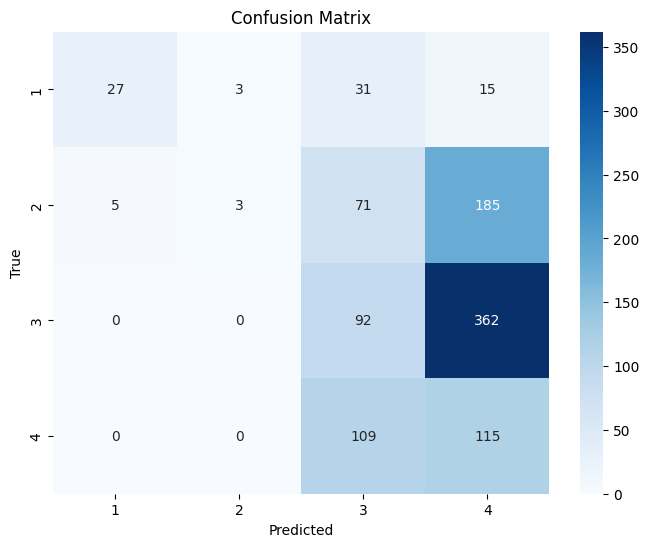

accuracy for class 1: 0.355
accuracy for class 2: 0.011
accuracy for class 3: 0.203
accuracy for class 4: 0.513


In [73]:
points_list = [-0.13933046, -1.23123677,  1.55182841,  2.87372761, -0.13350869,
        0.09458333,  0.50473512, -1.98096145, -0.85542722]
intercept = points_list[0] # the first element is the intercept
points_list = points_list[1:] 

encoded_X = encoded_X.drop(columns=['target']) 

# evaluate the model
evaluate_riskslim_model(points_list, SBC(), encoded_X, train_y, intercept)

### ensemble of scorecards --> add column to aesthetic data of total number of points assigned by old scorecard and give that data to my scorecard

In [80]:
def old_scorecard_points(features) :    
    points = 0.0

    # 'pLBC'
    if (features[8]<0.0174):
        points = 0
    elif (features[8]<0.1012):
        points = 0.1538
    elif (features[8]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    # 'pBCE'
    if (features[10]<0.0184):
        points += 0
    elif (features[10]<0.3684):
        points += 0.0636
    elif (features[10]<0.9219):
        points += 0.1938
    else :
        points += 0.2128
    
    return points

Objective Evaluation accuracy: 0.597

Evaluating the model on the test set...
test predictions:  [0 0 0 ... 1 1 1]
     True Value  Prediction
0             2           1
1             2           2
2             4           3
3             3           2
4             3           3
..          ...         ...
335           3           3
336           3           3
337           4           3
338           4           3
339           4           4

[340 rows x 2 columns]
accuracy:  0.5588235294117647
precision:  0.5752406282969729
recall:  0.5588235294117647
f1 score:  0.5459514860335967
balanced accuracy:  0.5088536453585462
logistic loss:  0.006196205734967575
mse:  0.4852941176470588
number of far off predictions:  13
number of features:  117
number of non-zero weights:  61
model size (non-zero weights / all weights):  0.5213675213675214


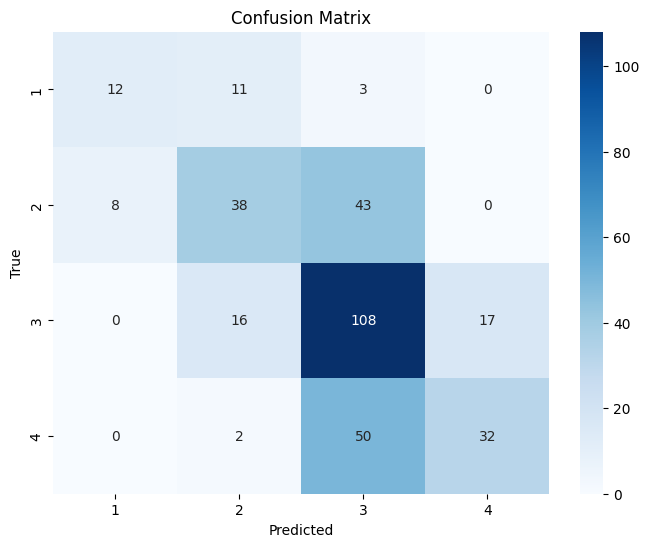

accuracy for class 1: 0.462
accuracy for class 2: 0.427
accuracy for class 3: 0.766
accuracy for class 4: 0.381

Evaluating the model on the train set...
accuracy on train set:  0.6552062868369352
precision on train set:  0.6691521596937459
recall on train set:  0.6552062868369352
f1 score on train set:  0.643245848452293
balanced accuracy on train set:  0.6154910563729106
logistic loss on train set:  0.010347884713928494
mse on train set:  0.3929273084479371

Scorecard table:
                Feature    Weight
0    featBRA Value-bin1  0.000000
1    featBRA Value-bin2  0.246161
2    featBRA Value-bin3  0.000000
3    featBRA Value-bin4  0.054829
4    featBRA Value-bin5  0.000000
35  featpBRA Value-bin1  1.020877
36  featpBRA Value-bin2  0.000000
37  featpBRA Value-bin3 -0.106833
38  featpBRA Value-bin4  0.287820
39  featpBRA Value-bin5  0.000000
                Feature    Weight
5    featLBC Value-bin1  0.228942
6    featLBC Value-bin2  0.000000
7    featLBC Value-bin3  0.064093
8    fea

In [ ]:
from scorecard import Scorecard

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_objective_evaluation = aesthetic_evaluation_data['Objective Evaluation']
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# add column 'points' to X, calculated by old_scorecard_points
for i in range(aesthetic_evaluation_X.shape[0]):
    features = aesthetic_evaluation_X.iloc[i].values
    points = old_scorecard_points(features)
    aesthetic_evaluation_X.loc[i, 'points'] = points
    
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                               thresholds_method='CAIM',
                               encoding_method='1_OUT_OF_K',
                               model_method='ML',
                               params= {'C': 1.1111111111111112, 'class_weight': None},
                               use_sbc=True,
                               K=4,
                               mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                               )

# see accuracy of 'Objective Evaluation' on test set
test = scorecard.test_X
test_objective = aesthetic_evaluation_objective_evaluation.loc[test.index]
objective_acc = accuracy_score(test_objective, scorecard.test_y)
print(f'Objective Evaluation accuracy: {objective_acc:.3f}')

scorecard.evaluate()

scorecard.show_scorecard()


Evaluating the model on the test set...
test predictions:  [1 0 0 ... 1 1 1]
     True Value  Prediction
0             2           2
1             2           2
2             4           3
3             3           2
4             3           3
..          ...         ...
335           3           2
336           3           3
337           4           3
338           4           3
339           4           4

[340 rows x 2 columns]
accuracy:  0.55
precision:  0.569053431484857
recall:  0.55
f1 score:  0.5436427967127252
balanced accuracy:  0.5025766030128928
logistic loss:  0.006868084672528094
mse:  0.49411764705882355
number of far off predictions:  13
number of features:  117
number of non-zero weights:  112
model size (non-zero weights / all weights):  0.9572649572649573


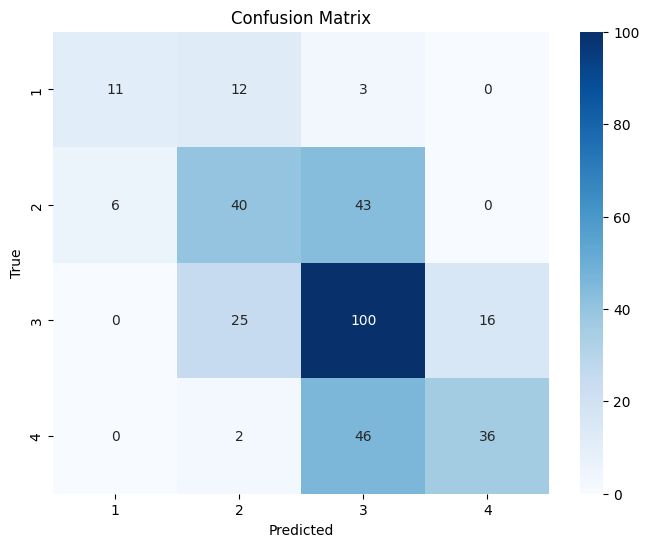

accuracy for class 1: 0.423
accuracy for class 2: 0.449
accuracy for class 3: 0.709
accuracy for class 4: 0.429

Evaluating the model on the train set...
accuracy on train set:  0.6414538310412574
precision on train set:  0.6466542904459451
recall on train set:  0.6414538310412574
f1 score on train set:  0.6324167867536137
balanced accuracy on train set:  0.6082715690532899
logistic loss on train set:  0.010417279161351992
mse on train set:  0.41846758349705304

Scorecard table:
                Feature    Weight
0    featBRA Value-bin1  0.080268
1    featBRA Value-bin2  0.080430
2    featBRA Value-bin3 -0.012401
3    featBRA Value-bin4  0.129751
4    featBRA Value-bin5 -0.278048
35  featpBRA Value-bin1  0.542874
36  featpBRA Value-bin2 -0.150871
37  featpBRA Value-bin3 -0.200336
38  featpBRA Value-bin4  0.086381
39  featpBRA Value-bin5 -0.278048
                Feature    Weight
5    featLBC Value-bin1  0.187247
6    featLBC Value-bin2  0.182007
7    featLBC Value-bin3 -0.103075
8    f

In [76]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                thresholds_method='CAIM',
                                encoding_method='1_OUT_OF_K',
                                model_method='MM',
                                params={'C': 8, 'class_weight': None},
                                use_sbc=True,
                                K=4,
                                mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()


Evaluating the model on the test set...
test predictions:  [1 0 0 ... 1 1 1]
     True Value  Prediction
0             2           2
1             2           3
2             4           3
3             3           2
4             3           3
..          ...         ...
335           3           3
336           3           3
337           4           3
338           4           3
339           4           4

[340 rows x 2 columns]
accuracy:  0.5
precision:  0.5026119219617671
recall:  0.5
f1 score:  0.4896808486285564
balanced accuracy:  0.452895419187554
logistic loss:  0.007051460291438649
mse:  0.5970588235294118
number of far off predictions:  13
number of features:  22391
number of non-zero weights:  1052
model size (non-zero weights / all weights):  0.046983162877942033


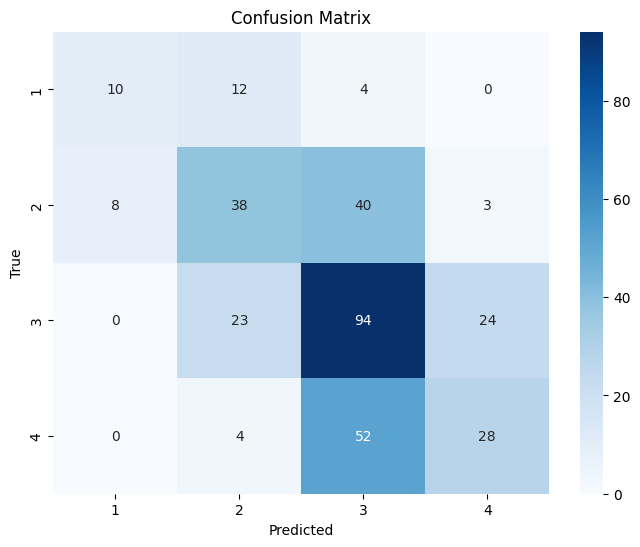

accuracy for class 1: 0.385
accuracy for class 2: 0.427
accuracy for class 3: 0.667
accuracy for class 4: 0.333

Evaluating the model on the train set...
accuracy on train set:  0.9685658153241651
precision on train set:  0.9691942523265129
recall on train set:  0.9685658153241651
f1 score on train set:  0.9685112252642833
balanced accuracy on train set:  0.9654768052490055
logistic loss on train set:  0.011580480441849825
mse on train set:  0.03143418467583497

Scorecard table:
                     Feature  Weight
0         featBRA Value-bin1     0.0
1         featBRA Value-bin2     0.0
2         featBRA Value-bin3     0.0
3         featBRA Value-bin4     0.0
4         featBRA Value-bin5     0.0
...                      ...     ...
8131  featpBRA Value-bin1013     0.0
8132  featpBRA Value-bin1014     0.0
8133  featpBRA Value-bin1015     0.0
8134  featpBRA Value-bin1016     0.0
8135  featpBRA Value-bin1017     0.0

[2034 rows x 2 columns]
                     Feature    Weight
1017    

In [77]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                 thresholds_method='INF_BINS',
                                 encoding_method='DIFF_CODING',
                                 model_method='ML',
                                 params={'C': 1.0101010101010102, 'class_weight': 'balanced'},
                                 use_sbc=True,
                                 K=4,
                                 mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                                )

scorecard.evaluate()

scorecard.show_scorecard()